# Работа выполнялась на локальной машине, а не в Google Colaboratory, поэтому некоторые блоки, связанные с загрузкой данных были переписаны или убраны.



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



## Импортируем нужные библиотеки

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
PIL.__version__

'8.4.0'



---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [3]:
!ls train

simpsons_dataset


Данные ранее были скачаны: kaggle competitions download -c journey-springfield

In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 11 00:43:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 17%   34C    P8    13W / 175W |   1228MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


## Подготовим данные

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

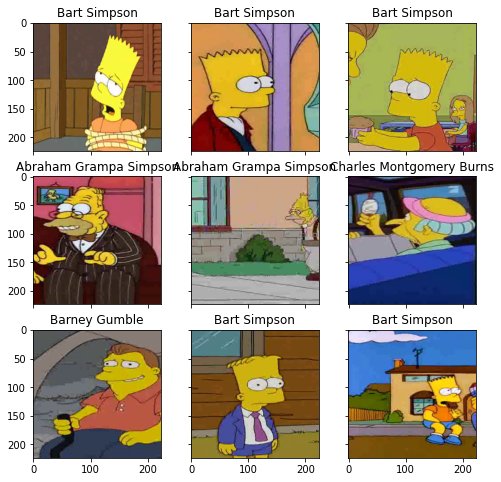

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Напишем функции для обучения модели и для получения предсказаний

### Функция эпохи обучения на тренировочной выборке

In [14]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    scheduler.step()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

### Функция эпохи вычисления loss и acc на валидационной выборке

In [15]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

### Функция для тренировки модели

In [16]:
def train(train_files, val_files, model, opt, scheduler, criterion, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # запомним веса лучшей модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    
    return model, history

### Функция для получения предсказаний модели

In [17]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Создадим нашу модель на основе модели ResNet

In [18]:
import torchvision.models as models

n_classes = len(np.unique(train_val_labels))
simple_cnn = models.resnet50(pretrained=True)

print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

In [19]:
for i, (name,param) in enumerate(simple_cnn.named_parameters()):
    print(i, name)

0 conv1.weight
1 bn1.weight
2 bn1.bias
3 layer1.0.conv1.weight
4 layer1.0.bn1.weight
5 layer1.0.bn1.bias
6 layer1.0.conv2.weight
7 layer1.0.bn2.weight
8 layer1.0.bn2.bias
9 layer1.0.conv3.weight
10 layer1.0.bn3.weight
11 layer1.0.bn3.bias
12 layer1.0.downsample.0.weight
13 layer1.0.downsample.1.weight
14 layer1.0.downsample.1.bias
15 layer1.1.conv1.weight
16 layer1.1.bn1.weight
17 layer1.1.bn1.bias
18 layer1.1.conv2.weight
19 layer1.1.bn2.weight
20 layer1.1.bn2.bias
21 layer1.1.conv3.weight
22 layer1.1.bn3.weight
23 layer1.1.bn3.bias
24 layer1.2.conv1.weight
25 layer1.2.bn1.weight
26 layer1.2.bn1.bias
27 layer1.2.conv2.weight
28 layer1.2.bn2.weight
29 layer1.2.bn2.bias
30 layer1.2.conv3.weight
31 layer1.2.bn3.weight
32 layer1.2.bn3.bias
33 layer2.0.conv1.weight
34 layer2.0.bn1.weight
35 layer2.0.bn1.bias
36 layer2.0.conv2.weight
37 layer2.0.bn2.weight
38 layer2.0.bn2.bias
39 layer2.0.conv3.weight
40 layer2.0.bn3.weight
41 layer2.0.bn3.bias
42 layer2.0.downsample.0.weight
43 layer2.0.do

In [20]:
# Замораживаем градиенты
layers_to_unfreeze = 89
for param in list(simple_cnn.parameters())[:-layers_to_unfreeze]:
    param.requires_grad = False

# Меняем классификатор
num_features = simple_cnn.fc.in_features
n_classes = len(np.unique(train_val_labels))
simple_cnn.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, n_classes)
)

# Переводим на gpu
if train_on_gpu:
    simple_cnn = torch.nn.DataParallel(simple_cnn).cuda()
    
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Оптимизатор
params_to_update = []
for name,param in simple_cnn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
optimizer = torch.optim.AdamW(params_to_update, lr=1e-4)

# Умножает learning_rate на 0.5 каждые 3 эпохи (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

	 module.layer3.0.conv1.weight
	 module.layer3.0.bn1.weight
	 module.layer3.0.bn1.bias
	 module.layer3.0.conv2.weight
	 module.layer3.0.bn2.weight
	 module.layer3.0.bn2.bias
	 module.layer3.0.conv3.weight
	 module.layer3.0.bn3.weight
	 module.layer3.0.bn3.bias
	 module.layer3.0.downsample.0.weight
	 module.layer3.0.downsample.1.weight
	 module.layer3.0.downsample.1.bias
	 module.layer3.1.conv1.weight
	 module.layer3.1.bn1.weight
	 module.layer3.1.bn1.bias
	 module.layer3.1.conv2.weight
	 module.layer3.1.bn2.weight
	 module.layer3.1.bn2.bias
	 module.layer3.1.conv3.weight
	 module.layer3.1.bn3.weight
	 module.layer3.1.bn3.bias
	 module.layer3.2.conv1.weight
	 module.layer3.2.bn1.weight
	 module.layer3.2.bn1.bias
	 module.layer3.2.conv2.weight
	 module.layer3.2.bn2.weight
	 module.layer3.2.bn2.bias
	 module.layer3.2.conv3.weight
	 module.layer3.2.bn3.weight
	 module.layer3.2.bn3.bias
	 module.layer3.3.conv1.weight
	 module.layer3.3.bn1.weight
	 module.layer3.3.bn1.bias
	 module.layer3.3.

## Запустим обучение нашей модели

In [21]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [22]:
model, history = train(train_dataset, val_dataset, simple_cnn, optimizer, exp_lr_scheduler, loss_fn, epochs=25, batch_size=64)

epoch:   0%|                                                                                    | 0/25 [00:00<?, ?it/s]C:\Users\fluch\anaconda3\envs\gpu\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss 1.206506531715727


epoch:   4%|██▉                                                                      | 1/25 [03:32<1:24:56, 212.35s/it]


Epoch 001 train_loss: 1.2065     val_loss 0.3739 train_acc 0.6985 val_acc 0.9066
loss 0.3603020738101976


epoch:   8%|█████▊                                                                   | 2/25 [06:52<1:18:33, 204.93s/it]


Epoch 002 train_loss: 0.3603     val_loss 0.3124 train_acc 0.9092 val_acc 0.9255
loss 0.12953973204637007


epoch:  12%|████████▊                                                                | 3/25 [10:04<1:13:07, 199.42s/it]


Epoch 003 train_loss: 0.1295     val_loss 0.1993 train_acc 0.9639 val_acc 0.9538
loss 0.07046448393912529


epoch:  16%|███████████▋                                                             | 4/25 [13:17<1:08:49, 196.66s/it]


Epoch 004 train_loss: 0.0705     val_loss 0.2209 train_acc 0.9807 val_acc 0.9559
loss 0.0548225785624593


epoch:  20%|██████████████▌                                                          | 5/25 [16:29<1:05:02, 195.11s/it]


Epoch 005 train_loss: 0.0548     val_loss 0.2200 train_acc 0.9845 val_acc 0.9553
loss 0.023563738575741375


epoch:  24%|█████████████████▌                                                       | 6/25 [19:42<1:01:33, 194.42s/it]


Epoch 006 train_loss: 0.0236     val_loss 0.1924 train_acc 0.9932 val_acc 0.9645
loss 0.013310212355661086


epoch:  28%|█████████████████████                                                      | 7/25 [22:55<58:11, 193.98s/it]


Epoch 007 train_loss: 0.0133     val_loss 0.2203 train_acc 0.9961 val_acc 0.9626
loss 0.008285218246656487


epoch:  32%|████████████████████████                                                   | 8/25 [26:08<54:48, 193.44s/it]


Epoch 008 train_loss: 0.0083     val_loss 0.2159 train_acc 0.9978 val_acc 0.9673
loss 0.0021039727765025246


epoch:  36%|███████████████████████████                                                | 9/25 [29:20<51:29, 193.09s/it]


Epoch 009 train_loss: 0.0021     val_loss 0.2411 train_acc 0.9996 val_acc 0.9696
loss 0.0010871046190412993


epoch:  40%|█████████████████████████████▌                                            | 10/25 [32:40<48:50, 195.34s/it]


Epoch 010 train_loss: 0.0011     val_loss 0.2668 train_acc 0.9997 val_acc 0.9696
loss 0.0007038014655587006


epoch:  44%|████████████████████████████████▌                                         | 11/25 [36:02<46:02, 197.30s/it]


Epoch 011 train_loss: 0.0007     val_loss 0.2905 train_acc 0.9998 val_acc 0.9700
loss 0.0004908637409110603


epoch:  48%|███████████████████████████████████▌                                      | 12/25 [39:25<43:07, 199.01s/it]


Epoch 012 train_loss: 0.0005     val_loss 0.2947 train_acc 0.9998 val_acc 0.9706
loss 0.00035982917508296


epoch:  52%|██████████████████████████████████████▍                                   | 13/25 [42:44<39:48, 199.02s/it]


Epoch 013 train_loss: 0.0004     val_loss 0.3084 train_acc 0.9999 val_acc 0.9702
loss 0.00029026811920153


epoch:  56%|█████████████████████████████████████████▍                                | 14/25 [46:18<37:20, 203.64s/it]


Epoch 014 train_loss: 0.0003     val_loss 0.3105 train_acc 0.9999 val_acc 0.9694
loss 0.0002207436388404147


epoch:  60%|████████████████████████████████████████████▍                             | 15/25 [49:52<34:25, 206.54s/it]


Epoch 015 train_loss: 0.0002     val_loss 0.3178 train_acc 0.9999 val_acc 0.9694
loss 0.00020241228727628613


epoch:  64%|███████████████████████████████████████████████▎                          | 16/25 [53:25<31:18, 208.70s/it]


Epoch 016 train_loss: 0.0002     val_loss 0.3205 train_acc 0.9999 val_acc 0.9690
loss 0.00019197248283696084


epoch:  68%|██████████████████████████████████████████████████▎                       | 17/25 [56:59<28:00, 210.09s/it]


Epoch 017 train_loss: 0.0002     val_loss 0.3274 train_acc 0.9999 val_acc 0.9702
loss 0.0001682269568172851


epoch:  72%|███████████████████████████████████████████████████▊                    | 18/25 [1:00:32<24:38, 211.15s/it]


Epoch 018 train_loss: 0.0002     val_loss 0.3299 train_acc 0.9999 val_acc 0.9700
loss 0.00016423282576922649


epoch:  76%|██████████████████████████████████████████████████████▋                 | 19/25 [1:04:06<21:11, 211.88s/it]


Epoch 019 train_loss: 0.0002     val_loss 0.3306 train_acc 0.9999 val_acc 0.9692
loss 0.00014279373603325515


epoch:  80%|█████████████████████████████████████████████████████████▌              | 20/25 [1:07:40<17:43, 212.64s/it]


Epoch 020 train_loss: 0.0001     val_loss 0.3340 train_acc 0.9999 val_acc 0.9692
loss 0.00014515965441219442


epoch:  84%|████████████████████████████████████████████████████████████▍           | 21/25 [1:11:14<14:11, 212.91s/it]


Epoch 021 train_loss: 0.0001     val_loss 0.3353 train_acc 0.9999 val_acc 0.9692
loss 0.00014435852355554384


epoch:  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [1:14:47<10:39, 213.11s/it]


Epoch 022 train_loss: 0.0001     val_loss 0.3369 train_acc 0.9999 val_acc 0.9692
loss 0.00014099167981889126


epoch:  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [1:18:21<07:06, 213.13s/it]


Epoch 023 train_loss: 0.0001     val_loss 0.3386 train_acc 0.9999 val_acc 0.9692
loss 0.00012816347686672722


epoch:  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [1:21:53<03:32, 212.86s/it]


Epoch 024 train_loss: 0.0001     val_loss 0.3398 train_acc 0.9999 val_acc 0.9690
loss 0.00013169438420657553


epoch: 100%|████████████████████████████████████████████████████████████████████████| 25/25 [1:25:25<00:00, 205.00s/it]


Epoch 025 train_loss: 0.0001     val_loss 0.3411 train_acc 0.9999 val_acc 0.9690


## Построим кривые обучения

In [23]:
loss, acc, val_loss, val_acc = zip(*history)

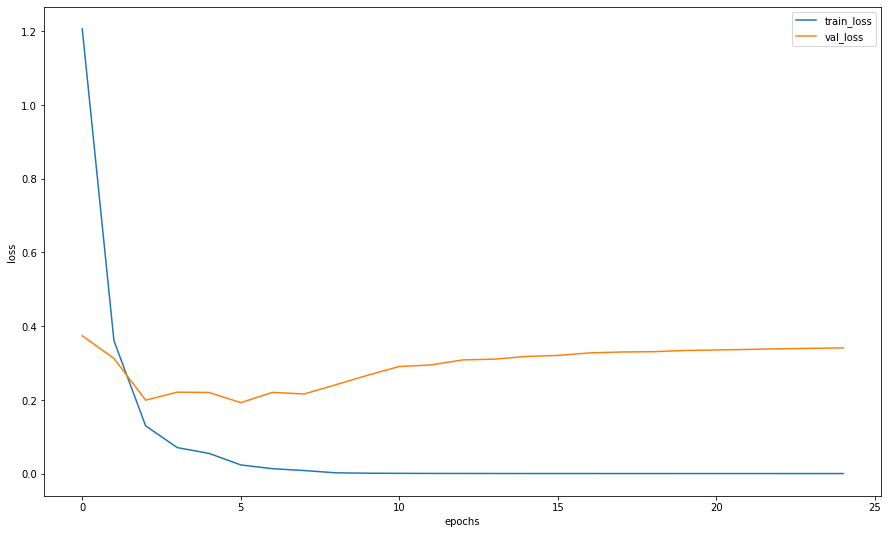

In [24]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [25]:
type(acc)

tuple

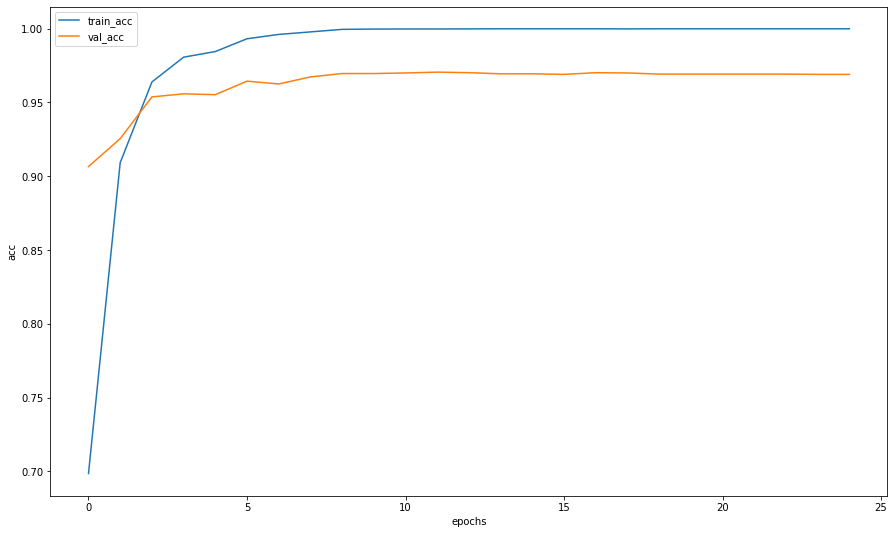

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
val_acc = tuple(t.cpu() for t in val_acc)
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

## Вычислим целевую метрику `F1` на валидационной выборке

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [34]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [36]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = np.array([val_dataset[id][1] for id in idxs])
preds_class = [label_encoder.classes_[i] for i in y_pred]

preds_class = [label_encoder.classes_[i] for i in y_pred]



In [37]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average = 'micro')

1.0

## Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах

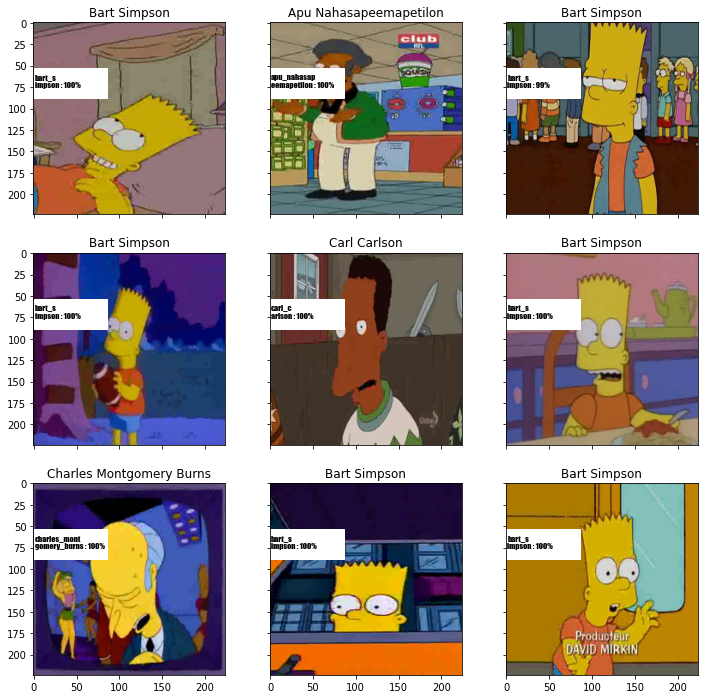

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

## Сделаем Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [39]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [40]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
#df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске
df.to_csv('./simpsons_resnet_baseline.csv', index=False)

In [41]:
df.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [42]:
torch.save(model.state_dict(), './simpsons_resnet.pth')

## Приключение?

Несколько срочныйх улучшейни для изначальной сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Всё получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


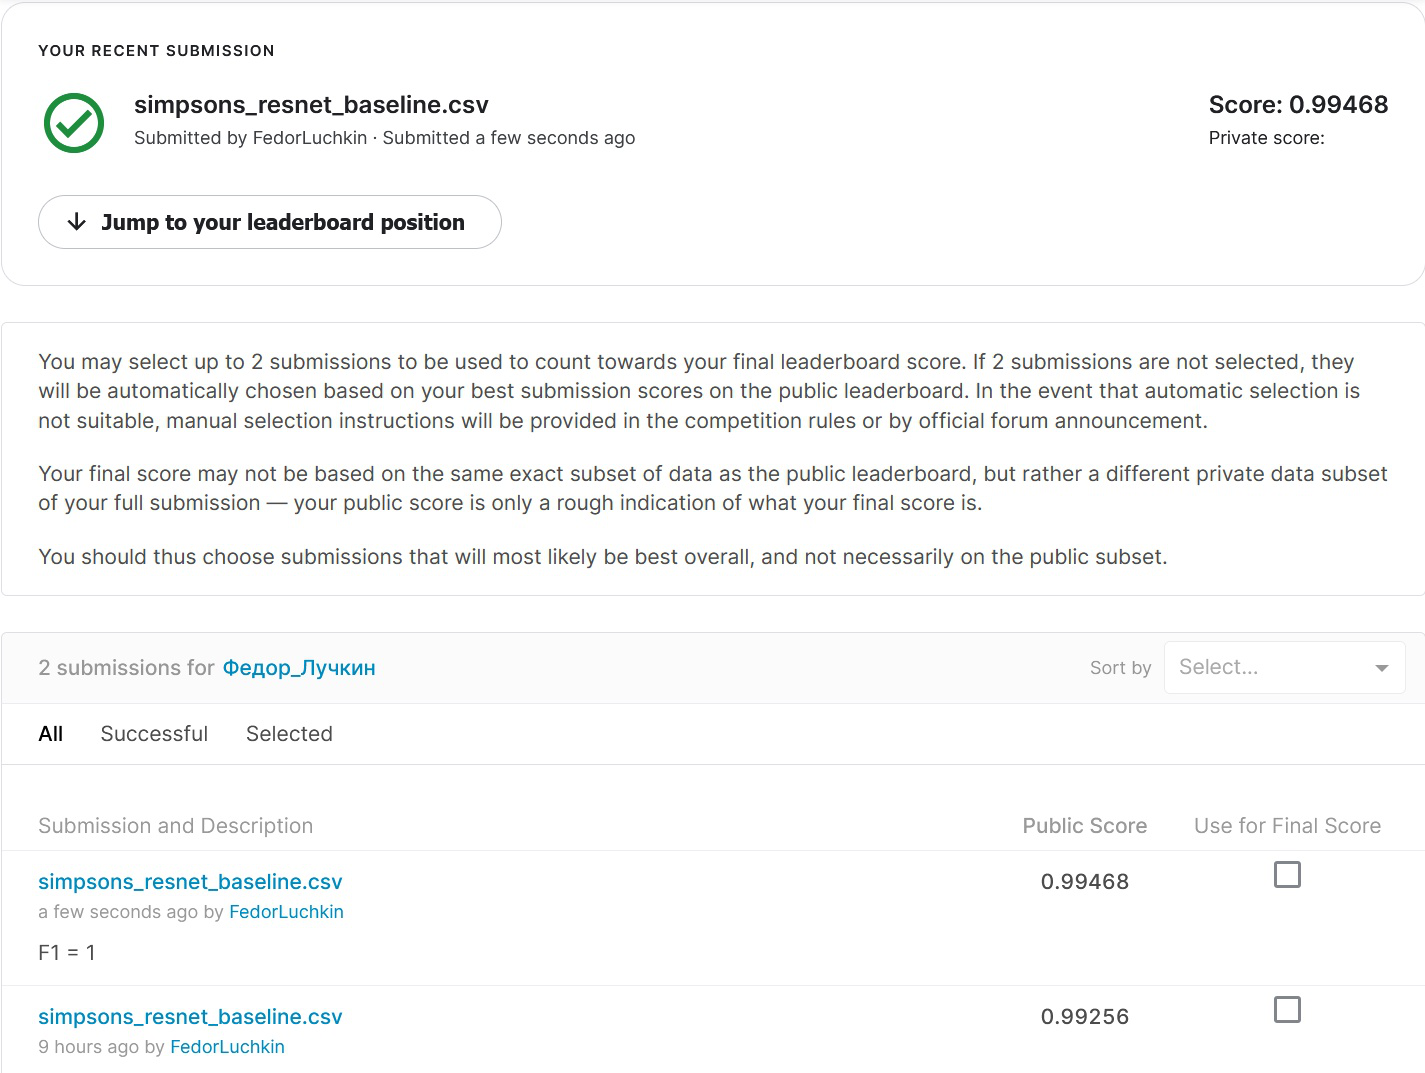

In [43]:
from urllib.request import urlopen
url = "https://sun1-85.userapi.com/impf/zhQ1llkgL_DaCZZ6wHIfiWUwW8jC9DAuiLDQdQ/tioh8w4MnTE.jpg?size=1425x1073&quality=95&sign=93962f7f43f77f64c18ace2f773d9b12&type=album"
Image.open(urlopen(url))

# Kaggle (15 баллов)

Критерии оценки следующие:

<font color='green'><strong>1) 0.99468 > 0.97: 15 баллов</strong></font>


0.96: 14 баллов

0.95: 13 баллов

...

0.84: 2 балла

0.83: 1 балл
